In [ ]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [240]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [241]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [242]:
data_dir = 'data' 

In [243]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

# 3. Load Data

In [244]:
# Set the path to the "data" directory
data_directory = "data"

# Paths to the "cats" and "dogs" folders within the "data" directory
cats_folder = os.path.join(data_directory, "cats")
dogs_folder = os.path.join(data_directory, "dogs")

# Get the list of image files in each folder
cat_images = [name for name in os.listdir(cats_folder) if os.path.isfile(os.path.join(cats_folder, name))]
dog_images = [name for name in os.listdir(dogs_folder) if os.path.isfile(os.path.join(dogs_folder, name))]

# Delete images from the "cats" folder until there are only 600 left
while len(cat_images) > 600:
    os.remove(os.path.join(cats_folder, cat_images.pop()))

# Delete images from the "dogs" folder until there are only 600 left
while len(dog_images) > 600:
    os.remove(os.path.join(dogs_folder, dog_images.pop()))

# Print the final counts
print(f"Final number of cat images: {len(cat_images)}")
print(f"Final number of dog images: {len(dog_images)}")

Final number of cat images: 600
Final number of dog images: 600


In [245]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 1200 files belonging to 2 classes.


In [246]:
data_iterator = data.as_numpy_iterator()

In [247]:
batch = data_iterator.next()

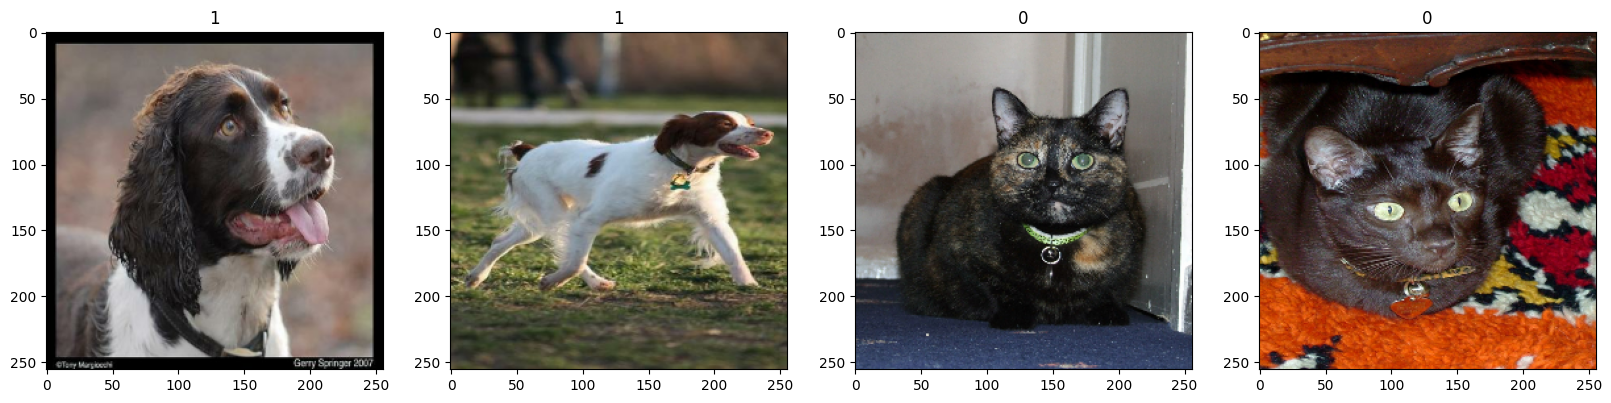

In [248]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [249]:
data = data.map(lambda x,y: (x/255, y))

In [250]:
data.as_numpy_iterator().next()

(array([[[[8.42000902e-01, 7.97628224e-01, 6.04198158e-01],
          [6.18661344e-01, 5.66507638e-01, 3.42297137e-01],
          [7.91094363e-01, 7.27908731e-01, 4.51842785e-01],
          ...,
          [4.37953323e-01, 5.43479621e-01, 1.38302907e-01],
          [3.57941151e-01, 5.58810234e-01, 1.19339049e-01],
          [4.51714247e-01, 6.56989336e-01, 2.35891908e-01]],
 
         [[7.69321322e-01, 7.19828546e-01, 4.95507926e-01],
          [4.55328614e-01, 4.74190027e-01, 1.93045586e-01],
          [6.63464725e-01, 6.92768753e-01, 3.27936620e-01],
          ...,
          [6.08468950e-01, 6.98412478e-01, 2.51264513e-01],
          [6.55052125e-01, 7.12299287e-01, 3.57023835e-01],
          [6.00719512e-01, 6.44931912e-01, 2.57006705e-01]],
 
         [[5.62592387e-01, 5.63889205e-01, 2.47555837e-01],
          [3.49818915e-01, 4.14661735e-01, 1.12054326e-01],
          [4.77569818e-01, 5.45476198e-01, 1.60082415e-01],
          ...,
          [5.70969164e-01, 6.91804647e-01, 3.0190

# 5. Split Data

In [251]:
len(data)

38

In [252]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [253]:
train_size+val_size+test_size

38

In [254]:
train_size

26

In [255]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [256]:
model = Sequential()

In [257]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])


In [258]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 127, 127, 16)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 62, 62, 32)      

# 7. Train

In [259]:
logdir='logs'

In [260]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [261]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
26/26 [==============================] - 16s 527ms/step - loss: 1.2444 - accuracy: 0.4892 - val_loss: 0.6932 - val_accuracy: 0.4688
Epoch 2/20
26/26 [==============================] - 15s 504ms/step - loss: 0.6921 - accuracy: 0.5252 - val_loss: 0.6929 - val_accuracy: 0.5039
Epoch 3/20
26/26 [==============================] - 17s 613ms/step - loss: 0.6930 - accuracy: 0.5108 - val_loss: 0.6925 - val_accuracy: 0.5586
Epoch 4/20
26/26 [==============================] - 15s 504ms/step - loss: 0.6759 - accuracy: 0.5889 - val_loss: 0.6812 - val_accuracy: 0.5586
Epoch 5/20
26/26 [==============================] - 15s 509ms/step - loss: 0.6814 - accuracy: 0.6094 - val_loss: 0.6794 - val_accuracy: 0.5742
Epoch 6/20
26/26 [==============================] - 19s 684ms/step - loss: 0.6541 - accuracy: 0.6430 - val_loss: 0.6600 - val_accuracy: 0.6367
Epoch 7/20
26/26 [==============================] - 20s 685ms/step - loss: 0.6538 - accuracy: 0.6394 - val_loss: 0.6465 - val_accuracy: 0.6680

# 8. Plot Performance

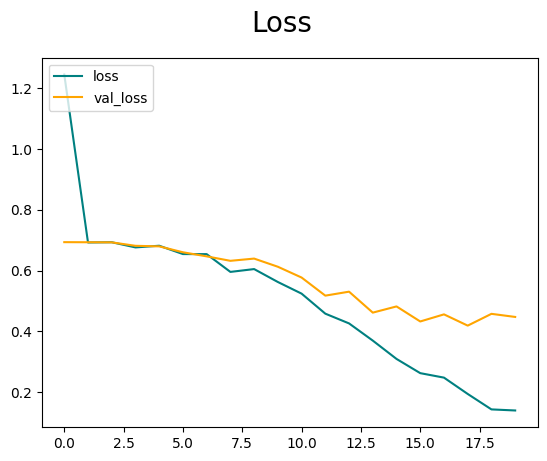

In [275]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

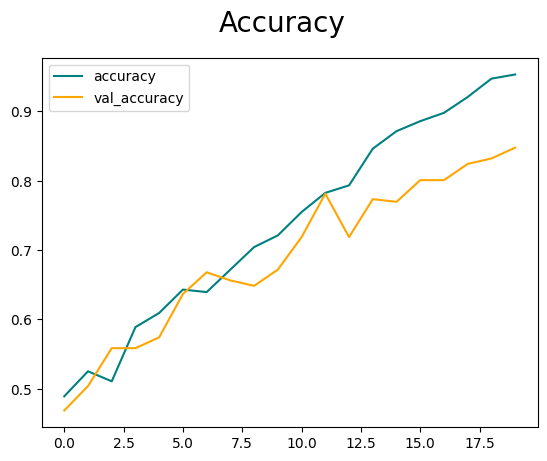

In [263]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [265]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [266]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 74ms/step


In [267]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.8035714, shape=(), dtype=float32) tf.Tensor(0.8035714, shape=(), dtype=float32) tf.Tensor(0.8035714, shape=(), dtype=float32)


# 10. Test

In [285]:
test_images_dir = 'testimages'

test_image_paths = [os.path.join(test_images_dir, fname) for fname in os.listdir(test_images_dir)]

def preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    return img_array

test_images = np.array([preprocess_image(path) for path in test_image_paths])

predictions = model.predict(test_images)

predicted_classes = ['Dog' if pred > 0.6 else 'Cat' for pred in predictions]

for path, pred in zip(test_image_paths, predictions):
    label = 'Dog' if pred > 0.3 else 'Cat'
    probability = pred[0] if label == 'Dog' else 1 - pred[0]
    print(f"{path}: {label} ({probability:.2%})")

1/1 [==============================] - 0s 27ms/step
testimages\cat_test1.jpg: Cat (98.82%)
testimages\cat_test2.jpg: Cat (73.74%)
testimages\cat_test3.jpg: Dog (50.44%)
testimages\cat_test4.jpg: Dog (50.17%)
testimages\cat_test5.jpg: Cat (99.80%)
testimages\dog_test1.jpg: Cat (91.31%)
testimages\dog_test2.jpg: Dog (50.56%)
testimages\dog_test3.jpg: Dog (64.35%)
testimages\dog_test4.jpg: Dog (93.02%)


# 11. Save the Model

In [ ]:
model.save(os.path.join('models','petdetector.h5'))

In [271]:
new_model = load_model('models/petdetector.h5')


In [272]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 52ms/step


array([[0.005999]], dtype=float32)